In [7]:
try:
    %matplotlib widget
    import sys
    import os
    import numpy as np
    from astroquery.mast import Observations
    from astropy.io import fits
    import matplotlib
    import matplotlib.pyplot as plt
    import astropy.units as u
    from scipy.signal import savgol_filter
    from astropy.timeseries import BoxLeastSquares
    import ipywidgets as widgets
    normalstdout=sys.stdout
except:
    print("Please be sure the following modules are installed:\n\n\tnumpy, matplotlib, scipy, ipympl, ipywidgets, astroquery, astropy\n\nThen restart this notebook.")

## Run the following cell to input a Kepler ID for analysis

In [107]:
#Gathering options for given keplername
#mainpath=input(f"Choose an existing filepath for data to be saved under\n(or press enter to save alongside this .py file)\n")
#if not mainpath:mainpath=os.getcwd()
mainpath=os.getcwd()
if mainpath[-1]=='/':mainpath=mainpath[:-1]
mainpath=mainpath.strip()
if not os.path.exists(mainpath):os.mkdir(mainpath)
keplername=input(f"\nChoose a Kepler ID (Kepler-10 for example)\n")

print(f"Gathering obs_id for {keplername}")
obs=Observations.query_criteria(obs_collection=["Kepler"],objectname=keplername,radius=0)
obs_list=list(obs['obs_id'])
flux_filt=err_filt=time_filt=filt=product=products=products_list=None
print("Done")


Choose a Kepler ID (Kepler-10 for example)
 Kepler-31


Gathering obs_id for Kepler-31
Done


## Run the following cell to choose an obs_id
### Short cadence (sc) data should yield better results, but will be slower to process

In [108]:
def obs_menu(obs_id=obs_list[0]):
    global products
    global products_list
    print("Loading...")
    products=Observations.get_product_list(obs[obs_list.index(obs_id)])
    products_list=list(products['description'])
    print("Done")
print("\nChoose an obs_id\n")
widgets.interact(obs_menu,obs_id=obs_list);


Choose an obs_id



interactive(children=(Dropdown(description='obs_id', options=('kplr009347899_sc_Q000000000333333332', 'kplr009…

## Run the following cell to choose a dataset
### Files of the same description will be automatically combined

In [109]:
def product_menu(description=products_list[0]):
    global product
    print("Loading...")
    product=Observations.filter_products(products,description=description)
    print("Done")
print("\nChoose a product\n")
widgets.interact(product_menu,description=products_list);


Choose a product



interactive(children=(Dropdown(description='description', options=('Preview-Full', 'tar file for Target Pixel …

## Run the following cell to download the data

In [127]:
#Collecting and combining data for chosen observation
time,flux,err=np.array([],np.float32),np.array([],np.float32),np.array([],np.float32)
#savedata=input("\nWould you like to save the data for future use? (y=yes, other=no)\n")
#if savedata.lower()=='y':savedata=True
#else:savedata=False
savedata=True
for i in range(len(product)):
    filepath=f"/mastDownload/{product['obs_collection'][i]}/{product['obs_id'][i]}/{product['productFilename'][i]}"
    if savedata and (not os.path.exists(f"{mainpath}{filepath}")):
        f=open(os.devnull,'w')
        print("Downloading Data...")
        print("(This may take a while)")
        sys.stdout=f
        Observations.download_products(product,download_dir=mainpath)
        f.close();sys.stdout=normalstdout
    temp=fits.open(f"{mainpath}{filepath}")[1].data
    time,flux,err=np.append(time,temp["TIME"]),np.append(flux,temp["SAP_FLUX"]),np.append(err,temp["SAP_FLUX_ERR"])
if len(time)<50:
    print("Warning: data contains <50 entries")

#Allow for saving plotted figures
if not os.path.exists(f"{mainpath}/plots"):os.mkdir(f"{mainpath}/plots")
#save=input("\nChoose a name.ext for saved plots (or press enter to use temp names)\n")
#if save=="":save="temp.pdf"
save="temp.pdf"
print("Done")

Done


## Run the following cell to plot the raw data
### The plots are interactive, allowing zooming in and saving images

Plotting Raw Data...


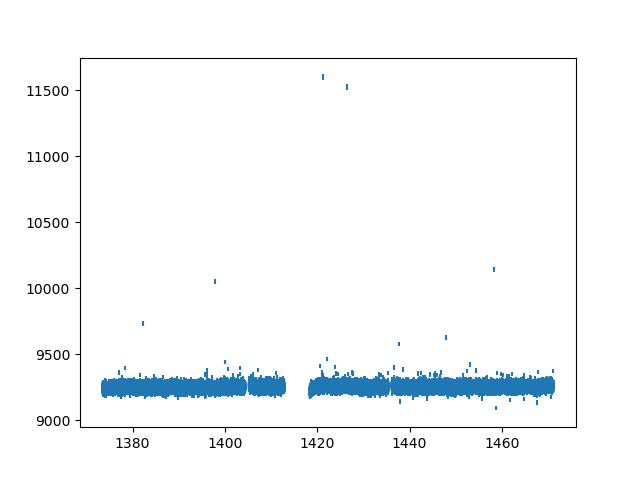

In [128]:
#Plotting raw data
print("Plotting Raw Data...")
plt.close(1)
plt.figure(1)
plt.errorbar(time,flux,err,fmt=',')
plt.savefig(f"{mainpath}/plots/raw_{save}")
plt.show()

## Run the following cell to filter the data
### A Savitzky–Golay filter is used, and its parameters can be adjusted

In [129]:
#Clean the data
#Remove NaN
t1=(~np.isnan(time))&(~np.isnan(flux))
time_clean=time[t1]
flux_clean=flux[t1]
err_clean=err[t1]
#Flatten data
window_text=widgets.IntText(101)
degree_text=widgets.IntText(2)
print("Press enter after changing the values")
def filter_menu(window=101,degree=2):
    global flux_filt,err_filt,time_filt
    print("Loading...")
    filt=savgol_filter(flux_clean,window,degree)
    flux_filt=flux_clean/filt
    err_filt=err_clean/filt
    #Remove outliers
    t1=np.abs(1-flux_filt)<2*np.std(flux_filt)
    time_filt=time_clean[t1]
    flux_filt=flux_filt[t1]
    err_filt=err_filt[t1]
    print("Done")
    print(f"Window: {window}\nDegree: {degree}")
widgets.interact(filter_menu,window=window_text,degree=degree_text);

Press enter after changing the values


interactive(children=(IntText(value=101, description='window'), IntText(value=2, description='degree'), Output…

## Run the following cell to plot the cleaned data

Plotting Cleaned Data...


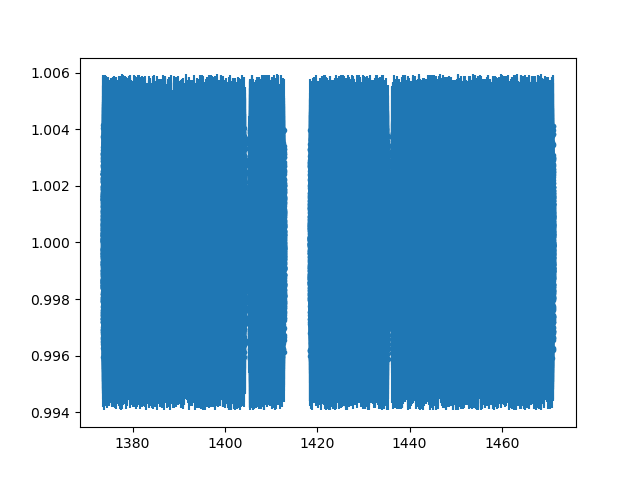

In [130]:
print("Plotting Cleaned Data...")
#filt=savgol_filter(flux_clean,51,2)
plt.close(2)
plt.figure(2)
plt.errorbar(time_filt,flux_filt,err_filt,fmt='.')
plt.savefig(f"{mainpath}/plots/clean_{save}")
plt.show()

## Run the following cell to plot the periodogram

In [ ]:
#Create box least squares model
print("Plotting Periodogram...")
model=BoxLeastSquares(time_filt,flux_filt)
periodogram=model.autopower(0.2)
plt.close(3)
plt.figure(3)
plt.plot(periodogram.period,periodogram.power)
plt.savefig(f"{mainpath}/plots/box_{save}")
plt.show()

Plotting Periodogram...


## Run the following cell to plot the folded data


Transit period in days appears to be: 37.15140344085268

Plotting Folded Data...


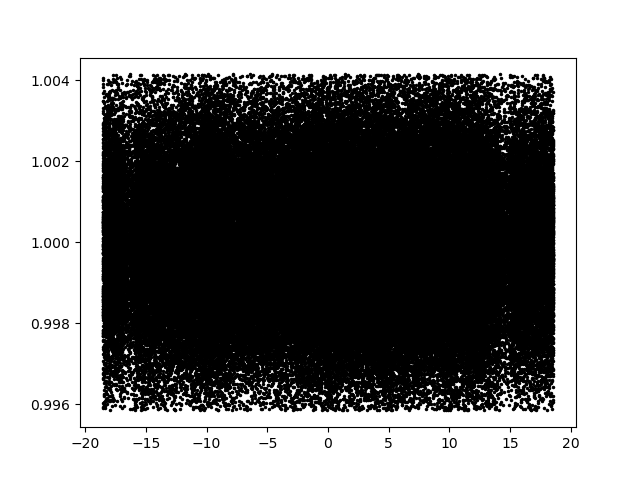

In [132]:
#Analyze model
max_power=np.argmax(periodogram.power)
period=periodogram.period[max_power]
print(f"\nTransit period in days appears to be: {period}\n")
stats=model.compute_stats(periodogram.period[max_power],periodogram.duration[max_power],periodogram.transit_time[max_power])
print("Plotting Folded Data...")
#Folded data
timefold=(time_filt-stats['transit_times'][0]-period/2)%period-period/2
plt.close(4)
plt.figure(4)
plt.plot(timefold,flux_filt,'.k',ms=3)
plt.savefig(f"{mainpath}/plots/fold_{save}")
plt.show()